In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from flygym import Fly, Camera, SingleFlySimulation
from tqdm import tqdm, trange
from flygym.examples.common import PreprogrammedSteps
from flygym.examples.rule_based_controller import (
    construct_rules_graph,
    RuleBasedSteppingCoordinator,
)
from viz import merge_frame_and_time_series
import imageio

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
# Initialize simulation
stabilization_time = 0.4
run_time = 1.0

enable_adhesion = True

fly = Fly(
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right",
    fps=30,
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

In [4]:
n_steps_base = round(run_time / sim.timestep)
n_stabilization_steps = round(stabilization_time / sim.timestep)
n_steps_total = n_steps_base + n_stabilization_steps

In [5]:
# Define rule variables
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]

In [6]:
preprogrammed_steps = PreprogrammedSteps()

# Initialize rule-based controller
weights = {
    "rule1": -10,
    "rule2_ipsi": 2.5,
    "rule2_contra": 1,
    "rule3_ipsi": 3.0,
    "rule3_contra": 2.0,
}
rules_graph = construct_rules_graph()
controller = RuleBasedSteppingCoordinator(
    timestep=sim.timestep,
    rules_graph=rules_graph,
    weights=weights,
    preprogrammed_steps=preprogrammed_steps,
    seed=42,
)

In [7]:
# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), n_steps_base))
all_legs_rule2_scores = np.zeros((len(legs), n_steps_base))
all_legs_rule3_scores = np.zeros((len(legs), n_steps_base))
all_leg_scores = np.zeros((len(legs), n_steps_base))

obs_list = []
all_initiated_legs = []
prev_mask_is_stepping = np.zeros(len(legs), dtype=bool)

In [8]:
sim.reset()
t_frames = []

# Run the actual simulation
for i in trange(n_steps_total):
    controller.step()

    is_new_stepping = ~prev_mask_is_stepping & controller.mask_is_stepping
    prev_mask_is_stepping[:] = controller.mask_is_stepping

    joint_angles = []
    adhesion_onoff = []

    for leg, phase in zip(controller.legs, controller.leg_phases):
        joint_angles_arr = controller.preprogrammed_steps.get_joint_angles(leg, phase)
        joint_angles.append(joint_angles_arr.flatten())
        adhesion_onoff.append(
            controller.preprogrammed_steps.get_adhesion_onoff(leg, phase)
        )

    action = {
        "joints": np.concatenate(joint_angles),
        "adhesion": np.array(adhesion_onoff),
    }

    obs = sim.step(action)[0]
    frame = sim.render()[0]

    if i >= n_stabilization_steps:
        j = i - n_stabilization_steps
        if is_new_stepping.any():
            for leg in np.where(is_new_stepping)[0]:
                all_initiated_legs.append((leg, j))

        obs_list.append(obs)
        if frame is not None:
            t_frames.append(sim.curr_time - stabilization_time)
        all_legs_rule1_scores[:, j] = controller.rule1_scores
        all_legs_rule2_scores[:, j] = controller.rule2_scores
        all_legs_rule3_scores[:, j] = controller.rule3_scores
        all_leg_scores[:, j] = controller.combined_scores

sim.close()

distances = obs_list[-1]["fly"][0, :2] - obs_list[n_stabilization_steps]["fly"][0, :2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 14000/14000 [00:23<00:00, 584.57it/s]

Forward distance travelled:  4.4463925
Lateral distance travelled:  -0.6988985


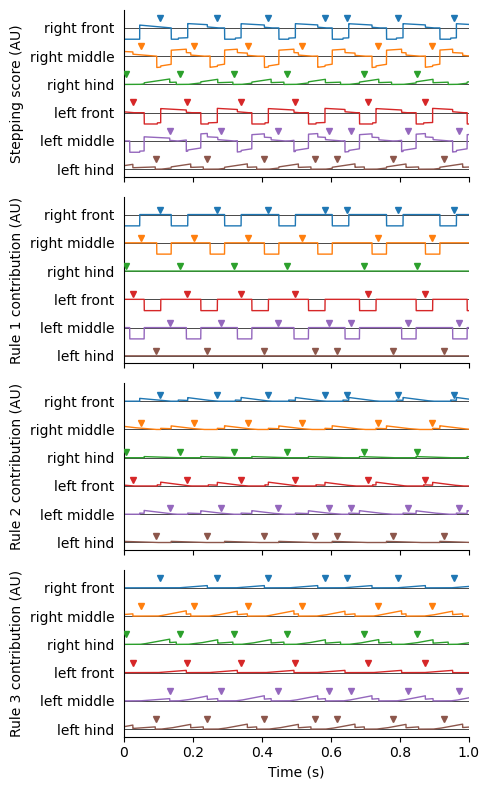

In [9]:
scores = {
    "Stepping score": all_leg_scores,
    "Rule 1 contribution": all_legs_rule1_scores,
    "Rule 2 contribution": all_legs_rule2_scores,
    "Rule 3 contribution": all_legs_rule3_scores,
}
time = np.arange(scores["Stepping score"].shape[1]) * sim.timestep
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}


def plot_frame(video_layout=False, spacing=25):
    if video_layout:
        fig, axs = plt.subplots(
            2, 2, figsize=(10, 4), sharex=True, sharey=True, tight_layout=True
        )
    else:
        fig, axs = plt.subplots(
            4, 1, figsize=(5, 8), sharex=True, sharey=True, tight_layout=True
        )

    lines = []

    for i, (score_name, score_ts) in enumerate(scores.items()):
        ax = axs.flatten()[i]
        for j, leg in enumerate(legs):
            offset = leg_basey_lookup[leg_name_lookup[leg]] * spacing
            ax.plot(
                time,
                score_ts[j, :] + offset,
                label=leg,
                color=color_lookup[leg],
                linewidth=1,
            )
            ax.axhline(offset, color="k", linestyle="-", linewidth=0.5, zorder=-1)
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * spacing)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
        ax.set_xlim(0, 1)
        ax.set_ylabel(f"{score_name} (AU)")
        if video_layout:
            ax.set_title(score_name)
        if i == 3 or (i == 2 and video_layout):
            ax.set_xlabel("Time (s)")
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])

        for leg_index, step in all_initiated_legs:
            leg = legs[leg_index]
            step_time = time[step - n_stabilization_steps]
            marker_heihgt = score_ts[j, :].max() + 4000 / 23000 * spacing
            offset = leg_basey_lookup[leg_name_lookup[leg]] * spacing
            ax.plot(
                step_time,
                offset + marker_heihgt,
                "v",
                color=color_lookup[leg],
                zorder=10,
                markersize=5,
            )
        ax.tick_params(left=False)

        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))

    sns.despine()
    return fig, lines


plt.style.use("default")
fig, lines = plot_frame()
Path("outputs").mkdir(exist_ok=True)
fig.savefig("outputs/rule_based.pdf", transparent=True)

In [10]:
plt.style.use("dark_background")
fig, lines = plot_frame(video_layout=True)

with imageio.get_writer("outputs/rule_based.mp4", fps=cam.fps) as writer:
    for t, frame in tqdm(
        zip(t_frames, cam._frames[-len(t_frames) :], strict=True), total=len(t_frames)
    ):
        writer.append_data(merge_frame_and_time_series(fig, lines, t, frame))

plt.close(fig)

100%|██████████| 300/300 [00:17<00:00, 17.25it/s]
